In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mtick
import string

%matplotlib inline

sns.axes_style({'font.family': ['sans-serif'],
        'font.sans-serif': ["Arial"],
        'xtick.labelsize' : 12,
        'ytick.labelsize' : 12,
        'axes.labelsize' : 12,
        });
sns.set(rc={'figure.figsize':tuple([4,4])})
sns.set_palette("pastel")
palette = sns.color_palette()

sns.set_style("whitegrid")

In [17]:
problem_id="native-10h"  # SELECT target problem

df = pd.read_csv(f"../{problem_id}/results.csv", index_col='Case')
n_cores = df['n_cores'].unique()
df['compat_frac'] = (df['compat_prod']/ df['total_prod']) *100
# Add generations
dfg = pd.read_csv(f"../generations/{problem_id}_avg_gen.tsv", sep='\t', index_col='Case')
df = df.join(dfg)

df.head()

,pop_size,n_cores,UCoverage,NSolutions,NUSolutions,DeltaP,GD,MinCS,compat_prod,total_prod,compat_frac,gen_avg,gen_std
Case,,,,,,,,,,,,,
0,100,4,0.004340,140,102,3.231596,0.027075,2,17,161,10.559006,552.0,283.9
1,100,16,0.022089,559,488,2.269254,0.008308,8,94,161,58.385093,432.4,245.9
2,100,32,0.045641,1171,974,1.973414,0.003462,7,91,161,56.521739,521.8,370.7
3,100,48,0.050566,1408,1118,1.978718,0.005227,7,86,161,53.416149,572.0,391.9
4,100,64,0.050712,1503,1220,1.938774,0.008023,6,89,161,55.279503,314.8,122.4


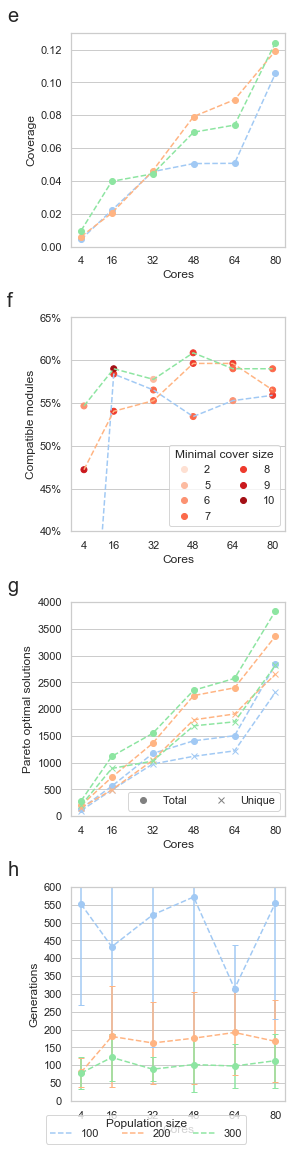

In [18]:
nr=4
nc=1
fig, axs = plt.subplots(nrows=nr, ncols=nc, figsize=(4*nc,4*nr))


def set_square(ax):
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))

# 0
ax = axs[0]
#g_labels = []
for idx, pop_size in enumerate(df['pop_size'].unique()):
    tdf = df[df['pop_size'] == pop_size]
    ax.plot(tdf['n_cores'],tdf['UCoverage'], '-o', ls='--')
    #g_labels.append(pop_size)
    
## Legend
patches = [ plt.plot([],[], ls="--", mec=None, color=palette[idx], 
            label="{:,.0f}".format(pop_size) )[0]  for idx, pop_size in enumerate(df['pop_size'].unique()) ]
plt.figlegend(handles=patches, title="Population size", loc = 'lower center', ncol=5, labelspacing=0.)#, bbox_to_anchor=(0.5, -0.05) )


## Axis
ax.set_xlabel("Cores")
ax.set_ylabel("Coverage")
ax.set_xticks(n_cores);
ax.grid(axis='x')
if 'native-10h' == problem_id:
    ax.set_ylim(bottom=0)
else:
    ax.set_ylim(bottom=0, top=0.2)

ax.yaxis.set_major_formatter(mtick.FormatStrFormatter(fmt = '%.2f'))
set_square(ax)

# 1
ax=axs[1]
# Minimal cover  formating
mcs_values = df['MinCS'].unique().tolist()
mcs_values.sort()
if plt.np.isnan(mcs_values[-1]):
    mcs_values.pop(-1)
mcs_colors = sns.color_palette("Reds",len(mcs_values))
mcs_dict = {k:v for k,v in zip(mcs_values,mcs_colors)}

def get_s(tdf):
    s = []
    for x in tdf['MinCS'].tolist():
        if plt.np.isnan(x):
            s.append([0,0,0]);
        else:
            s.append(mcs_dict[x])
    return s

g_labels = []
for idx, pop_size in enumerate(df['pop_size'].unique()):
    tdf = df[df['pop_size'] == pop_size]
    ax.plot(tdf['n_cores'],tdf['compat_frac'], ls='--')
    ax.scatter(tdf['n_cores'],tdf['compat_frac'], c=get_s(tdf))

patches = [ plt.plot([],[], marker="o", ms=6, ls="", mec=None, color=color, 
            label="{:,.0f}".format(label) )[0]  for label, color in zip(mcs_values, mcs_colors) ]
ax.legend(handles=patches, loc='lower right',ncol=2, numpoints=1 , title="Minimal cover size")

## Axis
ax.set_xlabel("Cores")
ax.set_ylabel("Compatible modules")
ax.set_xticks(n_cores);
ax.set_ylim(bottom=40, top=65)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter(fmt = '%.0f%%'))
ax.grid(axis='x')
set_square(ax)

# 2
ax=axs[2]
g_labels = []
for idx, pop_size in enumerate(df['pop_size'].unique()):
    tdf = df[df['pop_size'] == pop_size]
    ax.plot(tdf['n_cores'],tdf['NSolutions'], '-o', ls='--',c=palette[idx])
    g_labels.append(pop_size)
    ax.plot(tdf['n_cores'],tdf['NUSolutions'], '-x', ls='--',c=palette[idx])
    g_labels.append(pop_size)

## Legend
patches = [ plt.plot([],[], marker_type, ms=6, ls="", mec=None, color="gray", 
            label=marker_name)[0]  for marker_type, marker_name in zip(["-o","-x"], ["Total", "Unique"]) ]
ax.legend(handles=patches, loc='lower right',ncol=2, numpoints=1)

## Axis
ax.set_xlabel("Cores")
ax.set_ylabel("Pareto optimal solutions")
ax.set_xticks(n_cores);
ax.grid(axis='x')
ax.set_ylim(bottom=0, top=4000)
set_square(ax)

# 3 (generations)
ax=axs[3]
for idx, pop_size in enumerate(df['pop_size'].unique()):
    tdf = df[df['pop_size'] == pop_size]
   #ax.plot(tdf['n_cores'],tdf['gen_avg'], '-o', ls='--')
    ax.errorbar(tdf['n_cores'],tdf['gen_avg'],tdf['gen_std'] ,linestyle='--', marker='o', capsize=3)
## Axis
ax.set_xlabel("Cores")
ax.set_ylabel("Generations")
ax.set_xticks(n_cores);
ax.grid(axis='x')    
#if 'native-10h' == problem_id:
ax.set_ylim(bottom=0,top=600)
ax.set_yticks(pd.np.linspace(0,600,13))
#else:
    #ax.set_ylim(bottom=0,top=350)
set_square(ax)

# Overall
for n, ax in enumerate(axs.flatten()):
    if 'native-10h' == problem_id:
        n = n+4
    ax.text(-0.3, 1.05, string.ascii_lowercase[n], transform=ax.transAxes, 
            size=20)
    
plt.tight_layout()
plt.savefig(f"raw/{problem_id}.svgz", bbox_inches='tight')

# Previous 

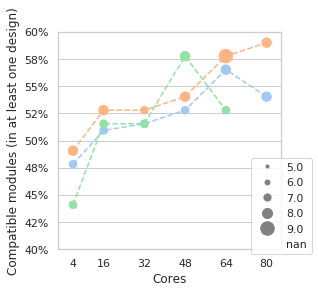

In [176]:

# Attempt with different sizes, it is hard to visualize (and to program)
nr=1
nc=1
fig, axs = plt.subplots(nrows=nr, ncols=nc, figsize=(4*nc,4*nr))

# Minimal cover sizes:
# ( do log scaling)
mcs_values = df['MinCS'].unique().tolist()
mcs_values.sort()
mcs_sizes = [v**2.5 for v in mcs_values]
mcs_dict = dict(zip(values,sizes))

def get_s(tdf):
    s = []
    for x in tdf['MinCS'].tolist():
        if plt.np.isnan(x):
            s.append(0);
        else:
            s.append(mcs_dict[x])
    return s

g_labels = []
for idx, pop_size in enumerate(df['pop_size'].unique()):
    tdf = df[df['pop_size'] == pop_size]
    plt.plot(tdf['n_cores'],tdf['compat_frac'], '-o', ls='--' )

    plt.scatter(tdf['n_cores'],tdf['compat_frac'], s=get_s(tdf))

    # s=tdf['MinCS'].tolist()
    #g_labels.append(pop_size)

# Legend
#lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
#lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
#labels = []
#fig.legend(lines, labels, title="Population size")

patches = [ plt.plot([],[], marker="o", ms=size/18, ls="", mec=None, color='gray', 
            label="{}".format(label) )[0]  for label, size in zip(mcs_values, mcs_sizes) ]
plt.legend(handles=patches, bbox_to_anchor=(1, 0.2), 
           loc='center', numpoints=1 )

## Axis
ax=axs
ax.set_xlabel("Cores")
ax.set_ylabel("Compatible modules (in at least one design)")
ax.set_xticks(n_cores);
plt.grid(axis='x')
ax.set_ylim(bottom=40, top=60)
#ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))


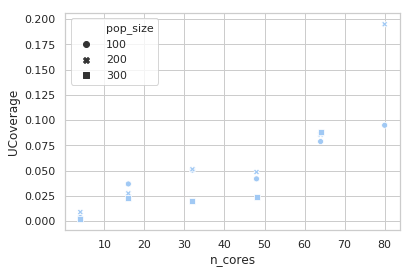

In [4]:
ax = sns.scatterplot(x="n_cores", y="UCoverage", data=df, style="pop_size")

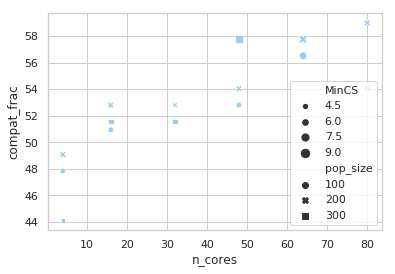

In [10]:
ax = sns.scatterplot(x="n_cores", y="compat_frac", data=df, style="pop_size", size="MinCS")